Window 1:
	Segment 1: x=178, y=190, w=47, h=81
Window 2:
	Segment 1: x=66, y=282, w=44, h=77
Window 3:
	Segment 1: x=0, y=99, w=45, h=83
Window 4:
	Segment 1: x=110, y=192, w=44, h=76
Window 5:
	Segment 1: x=517, y=281, w=47, h=79
Window 6:
	Segment 1: x=336, y=9, w=50, h=82
Window 7:
	Segment 1: x=222, y=281, w=46, h=84
Window 8:
	Segment 1: x=66, y=93, w=48, h=88
Window 9:
	Segment 1: x=290, y=97, w=48, h=84
Window 10:
	Segment 1: x=223, y=98, w=45, h=80
Window 11:
	Segment 1: x=449, y=282, w=44, h=75
Window 12:
	Segment 1: x=112, y=8, w=47, h=83
Window 13:
	Segment 1: x=406, y=12, w=43, h=76
Window 14:
	Segment 1: x=401, y=191, w=50, h=78
Window 15:
	Segment 1: x=289, y=281, w=47, h=79
Window 16:
	Segment 1: x=518, y=98, w=46, h=84
Window 17:
	Segment 1: x=0, y=281, w=42, h=77
Window 18:
	Segment 1: x=176, y=6, w=50, h=85
Window 19:
	Segment 1: x=337, y=193, w=44, h=77
Window 20:
	Segment 1: x=448, y=103, w=46, h=75


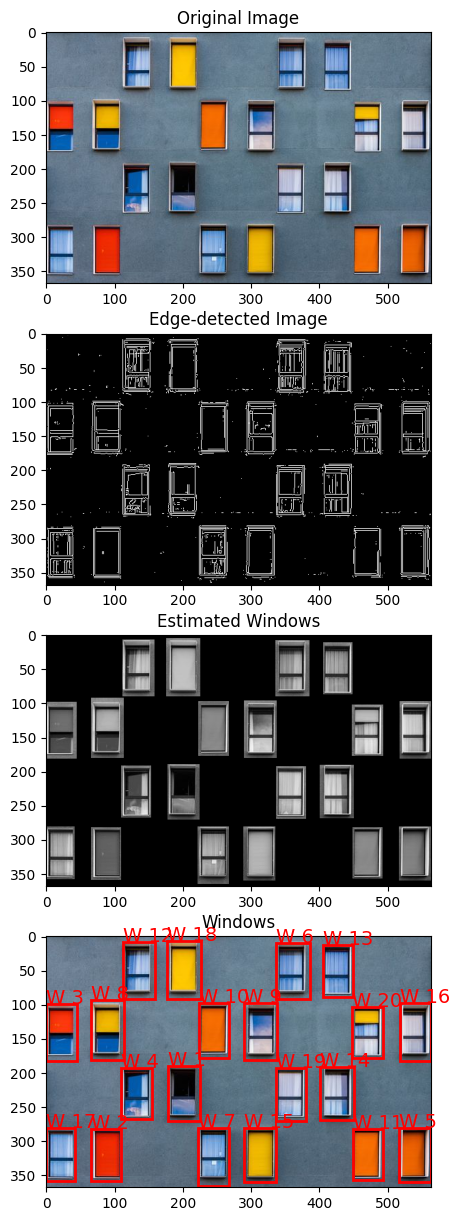

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches

# Load image and convert to grayscale
img = cv2.imread("re.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply Canny edge detection with low threshold
edges = cv2.Canny(gray,80, 80)

# Close polygons
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

# Extract vertical and horizontal segment primitives
horizontal = np.copy(closed)
vertical = np.copy(closed)
cols = horizontal.shape[1]

horizontal_size = cols // 45
horizontal_structure = cv2.getStructuringElement(cv2.MORPH_RECT, (horizontal_size, 1))
horizontal = cv2.erode(horizontal, horizontal_structure)
horizontal = cv2.dilate(horizontal, horizontal_structure)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
horizontal = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

vertical_size = cols // 76
vertical_structure = cv2.getStructuringElement(cv2.MORPH_RECT, (1, vertical_size))
vertical = cv2.erode(vertical, vertical_structure)
vertical = cv2.dilate(vertical, vertical_structure)

# Combine horizontal and vertical segment primitives
segments = cv2.add(horizontal, vertical)

# Find contours and filter out small segments
contours, _ = cv2.findContours(segments, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
window_segments = []
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    if w > 40 and h > 70:
        window_segments.append((x, y, w, h))

# Define function to calculate distance between segments
def distance(seg1, seg2):
    x1, y1, w1, h1 = seg1
    x2, y2, w2, h2 = seg2
    if y1 == y2:
        return abs(x2 - (x1 + w1))
    else:
        return abs(y2 - (y1 + h1))

# Define function to assemble window segments
def assemble_segments(segments, threshold):
    windows = []
    while segments:
        seed = segments.pop(0)
        window = [seed]
        i = 0
        while i < len(segments):
            if distance(seed, segments[i]) < threshold:
                window.append(segments.pop(i))
                i = 0
            else:
                i += 1
        windows.append(window)
    return windows

# Assemble window segments
windows = assemble_segments(window_segments, 10)

# Calculate score for each window assembly
scores = []
for window in windows:
    score = 0
    for segment in window:
        x, y, w, h = segment
        score += np.mean(gray[y:y+h, x:x+w])
    scores.append(score / len(window))

# Select windows with highest scores
best_windows = []
for i in np.argsort(scores)[-20:]:
    best_windows.append(windows[i])

# Create new image with estimated windows
new_img = np.zeros(gray.shape, dtype=np.uint8)
for window in best_windows:
    for segment in window:
        x, y, w, h = segment
        new_img[y:y+h, x:x+w] = gray[y:y+h, x:x+w]
        
for i, window in enumerate(best_windows):
    print(f"Window {i+1}:")
    for j, segment in enumerate(window):
        x, y, w, h = segment
        print(f"\tSegment {j+1}: x={x}, y={y}, w={w}, h={h}")

# Display images
fig, axs = plt.subplots(4, 1, figsize=(20, 15))
axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
axs[0].set_title("Original Image")
axs[1].imshow(edges, cmap="gray")
axs[1].set_title("Edge-detected Image")
axs[2].imshow(new_img, cmap="gray")
axs[2].set_title('Estimated Windows')

# Create new image with estimated windows

for i, window in enumerate(best_windows):
    for segment in window:
        x, y, w, h = segment
        new_img[y:y+h, x:x+w] = gray[y:y+h, x:x+w]
        axs[3].add_patch(patches.Rectangle((x, y), w, h, fill=False, edgecolor='r', linewidth=2))
    axs[3].text(window[0][0], window[0][1], f"W {i+1}", color='r', fontsize=14)
        
axs[3].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
axs[3].set_title('Windows')

plt.show()
